# Yelp dataset

## Import

In [1]:
import pandas as pd
import os.path
import numpy as np
from tqdm import tqdm
import swifter
from sklearn.preprocessing import MinMaxScaler

## Clean and merge
Load the dataset in chunk to avoid memory overflow, delete not used column, and merge it with info about business activities

In [2]:
def build_yelp_dataset():
    if os.path.exists('yelp dataset/yelp_dataset_merged.csv'):
        return
    df = pd.read_json('yelp dataset/yelp_academic_dataset_business.json', lines=True)
    df = df[df.is_open == 1] # consider only opened business
    df = df.reset_index(drop=True)
    df = df[['business_id', 'latitude', 'longitude']] # keep only this columns

    chunk_list = []  # append each chunk df here 
    # open the big review dataset in little chunk
    for count,chunk in enumerate(pd.read_json('yelp dataset/yelp_academic_dataset_review.json', lines=True, chunksize=500000)):
        chunk = chunk[['user_id', 'business_id', 'stars', 'date']]
        chunk = pd.merge(chunk, df, on='business_id') # merge business dataset and review dataset chunk
        chunk_list.append(chunk)
        print(f'processed {count + 1} chunks')
    df_concat = pd.concat(chunk_list)
    df_concat.to_csv('yelp dataset/yelp_dataset_merged.csv', index = False) # save dataset to CSV file

## Dataset preprocessing
We use the following contextual features: 
- year
- month
- day of the week
- week number
- longitude
- latitude

We extracted further contextual features from the date and location features: 
- season
- isHoliday
- isWeekend.

In [3]:
df = pd.read_csv('yelp dataset/yelp_dataset_merged.csv')
df.rename(columns={'user_id': 'user', 'business_id': 'item'}, inplace=True)

# convert user and item IDs to int64
df.user = pd.factorize(df.user)[0]
df.item = pd.factorize(df.item)[0]
df

,user,item,stars,date,latitude,longitude
0,0,0,2,2015-04-15 05:21:16,36.112896,-115.177637
1,1,0,2,2014-03-14 08:24:25,36.112896,-115.177637
2,2,0,3,2015-10-07 22:16:59,36.112896,-115.177637
3,3,0,2,2015-11-18 22:20:55,36.112896,-115.177637
4,4,0,3,2010-10-10 01:27:31,36.112896,-115.177637
...,...,...,...,...,...,...
6886520,1836147,159135,1,2019-12-09 18:57:49,43.686134,-79.607682
6886521,966056,167634,5,2019-02-13 19:53:09,36.128561,-115.171130
6886522,264157,156531,1,2019-12-04 19:01:23,33.304061,-111.979869
6886523,431787,166910,1,2012-07-31 03:34:14,36.112846,-115.225469


In [4]:
# return a season from a date in the format d/m/Y
def season_from_date(date):
    year = str(date.year)
    seasons = {1: pd.date_range(start='21/03/'+year, end='20/06/'+year), # spring
               2: pd.date_range(start='21/06/'+year, end='22/09/'+year), # summer
               3: pd.date_range(start='23/09/'+year, end='20/12/'+year)} # autumn
    if date in seasons[1]:
        return 'spring'
    elif date in seasons[2]:
        return 'summer'
    elif date in seasons[3]:
        return 'autumn'
    else:
        return 'winter'

# faster version that consider genuary, february and march as winter and so on... you don't consider the day
def season_from_date_fast(date):
    seasons = np.arange(12)
    seasons = seasons.reshape(4, 3) # reshape to a 2D matrix
    i, j = np.where(seasons == date.month - 1) # get row where month appears
    return i[0] + 1 # 1 = winter, 2 = spring, 3 = summer, 4 = autumn

In [5]:
# CONTEXT FEATURES TO ADD:
# year, month, day of the week, week number --> season, isHoliday, and isWeekend.
# df['date'] = pd.to_datetime(df['date']).dt.strftime('%d/%m/%Y') # convert date from object to date type to string as d/m/Y
# df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y') # convert back to date

In [6]:
# tqdm.pandas() 
# df['season'] = df[:1000]['date'].progress_apply(season_from_date) # get season from month and day

#df['season'] = df[:10]['date'].swifter.apply(season_from_date) # run apply function in parallel with swifter to get season from date
#df

In [7]:
df['date'] = pd.to_datetime(df['date']) # convert back to date
df['season'] = df['date'].swifter.apply(season_from_date_fast)

Dask Apply:   0%|          | 0/8 [00:00<?, ?it/s]

In [8]:
df['weekday'] = df['date'].dt.dayofweek # get day of the week from date
df['weekend'] = (df['weekday'] == 6) | (df['weekday'] == 5) # if is weekend from week day
df['weeknumber'] = df['date'].dt.isocalendar().week # get week number

In [9]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

In [10]:
df = df[['user', 'item', 'stars', 'month', 'year', 'weekday', 'weekend', 'weeknumber', 'season', 'latitude', 'longitude']]

## Encoding

- Categorical features **weekday**, **weekend** and **year** are encoded with one hot encoding.

- Cyclical features **month**, **week number** and **season** are encoded into two dimensions using a sine and cosine transformation:
$$
x_{sin} = \sin(\frac{2 \cdot \pi \cdot x}{max(x)}) \\
x_{cos} = \cos(\frac{2 \cdot \pi \cdot x}{max(x)})
$$
- Numeric features **latitude** and **longitude** are normalized


In [11]:
def sin_cos_encoding(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_val)
    return df

In [12]:
df = sin_cos_encoding(df, 'month', df.month.max()) # sin cos encoding for months
df = sin_cos_encoding(df, 'weeknumber', df.weeknumber.max()) # sin cos encoding for week number
df = sin_cos_encoding(df, 'season', df.season.max()) # sin cos encoding for seasons
df = df.drop(columns=['month', 'weeknumber', 'season'])

In [13]:
# convert categorical data to one-hot encoding
for col in ['weekday', 'year']:
    df = pd.get_dummies(df, columns=[col], prefix = [col])

df['weekend'] = df.weekend.astype('UInt8')

In [14]:
# min max normalization for latitude and longitude
mms = MinMaxScaler()
df[['latitude','longitude']] = mms.fit_transform(df[['latitude','longitude']])
df

,user,item,stars,weekend,latitude,longitude,month_sin,month_cos,weeknumber_sin,weeknumber_cos,...,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019
0,0,0,2,0,0.490413,0.502798,8.660254e-01,-5.000000e-01,0.947326,-0.320270,...,0,0,0,0,0,1,0,0,0,0
1,1,0,2,0,0.490413,0.502798,1.000000e+00,6.123234e-17,0.964636,0.263587,...,0,0,0,0,1,0,0,0,0,0
2,2,0,3,0,0.490413,0.502798,-8.660254e-01,5.000000e-01,-0.989040,0.147647,...,0,0,0,0,0,1,0,0,0,0
3,3,0,2,0,0.490413,0.502798,-5.000000e-01,8.660254e-01,-0.652822,0.757511,...,0,0,0,0,0,1,0,0,0,0
4,4,0,3,1,0.490413,0.502798,-8.660254e-01,5.000000e-01,-0.999561,0.029633,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6886520,1836147,159135,1,0,0.744526,0.920192,-2.449294e-16,1.000000e+00,-0.348202,0.937420,...,0,0,0,0,0,0,0,0,0,1
6886521,966056,167634,5,0,0.490939,0.502874,8.660254e-01,5.000000e-01,0.737833,0.674983,...,0,0,0,0,0,0,0,0,0,1
6886522,264157,156531,1,0,0.396166,0.540322,-2.449294e-16,1.000000e+00,-0.456629,0.889657,...,0,0,0,0,0,0,0,0,0,1
6886523,431787,166910,1,0,0.490412,0.502236,-5.000000e-01,-8.660254e-01,-0.508531,-0.861044,...,0,0,1,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6886525 entries, 0 to 6886524
Data columns (total 35 columns):
 #   Column          Dtype  
---  ------          -----  
 0   user            int64  
 1   item            int64  
 2   stars           int64  
 3   weekend         UInt8  
 4   latitude        float64
 5   longitude       float64
 6   month_sin       float64
 7   month_cos       float64
 8   weeknumber_sin  float64
 9   weeknumber_cos  float64
 10  season_sin      float64
 11  season_cos      float64
 12  weekday_0       uint8  
 13  weekday_1       uint8  
 14  weekday_2       uint8  
 15  weekday_3       uint8  
 16  weekday_4       uint8  
 17  weekday_5       uint8  
 18  weekday_6       uint8  
 19  year_2004       uint8  
 20  year_2005       uint8  
 21  year_2006       uint8  
 22  year_2007       uint8  
 23  year_2008       uint8  
 24  year_2009       uint8  
 25  year_2010       uint8  
 26  year_2011       uint8  
 27  year_2012       uint8  
 28  year_2013   

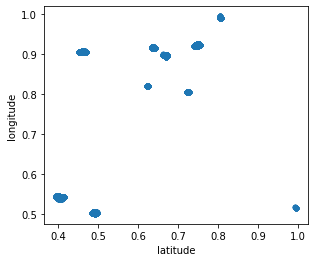

In [24]:
df.info(memory_usage='deep')
ax = df[:100000].plot.scatter('latitude', 'longitude').set_aspect('equal')

In [16]:
save_folder = 'final datasets'
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
df.to_csv(save_folder + '/yelp_final.csv', index = False) # save dataset to CSV file